# Generating a dataset with Q&A for our fragments dataset using OpenAI API

In [1]:
# extracted from optimism governance docs
file_path = "../../../data/002-governance-forum-202406014/dataset/_out.jsonl"

# openai api key
openai_api_key = input("Enter the OpenAI API key: ")

In [2]:
model_embeddings = "text-embedding-3-small"
model_chat = "gpt-4o"

In [3]:
# imports
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

from langchain_text_splitters import RecursiveJsonSplitter
import pandas as pd
import json
import matplotlib.pyplot as plt

In [4]:
# select the model
llm = ChatOpenAI(
    model = model_chat,
    temperature = 0,
    max_tokens = None,
    timeout = None,
    max_retries = 2,
    api_key = openai_api_key
)

In [6]:
def load_forum_posts(file_path):
    with open(file_path, 'r') as file:
        boards = {}
        threads = {}
        posts = {}
        for line in file:
            data_line = json.loads(line)
            type_line = data_line['type']
            try:
                id = data_line['item']['data']['id']
                match type_line:
                    case 'board':
                        boards[id] = {
                            'name': data_line['item']['data']['name'],
                            #"created_at": data_line['item']['data']['created_at'],
                            }
                    case 'thread':
                        threads[id] = {
                            'title': data_line['item']['data']['title'],
                            'category_id' : data_line['item']['data']['category_id'],
                            "created_at": data_line['item']['data']['created_at'],
                            "views": data_line['item']['data']['views'],
                            "like_count": data_line['item']['data']['like_count'],
                            }
                    case 'post':
                        posts[id] = {
                            #"cooked": data_line['item']['data']['cooked'],
                            #"url": data_line['item']['data']['url'],
                            #"link_counts": data_line['item']['data']['link_counts'],
                            "created_at": data_line['item']['data']['created_at'],
                            "username": data_line['item']['data']['username'],
                            "score": data_line['item']['data']['score'],
                            "readers_count": data_line['item']['data']['readers_count'],
                            "moderator": data_line['item']['data']['moderator'],
                            "admin": data_line['item']['data']['admin'],
                            "staff": data_line['item']['data']['staff'],
                            "trust_level": data_line['item']['data']['trust_level'],
                            "content": data_line['item']['content'],
                            "creation_time": data_line['item']['creation_time'],
                            "path": data_line['item']['path'],
                            "download_time": data_line['download_time'],
                        }
                    case _:
                        print(f"Unknown type: {type_line}")
            except:
                #print(f"Error processing line: {line}")
                None

    for id_post in posts:
        path = posts[id_post]['path']

        try:
            id_board = int(path[0])
            posts[id_post]['board_name'] = boards[id_board]['name']
            posts[id_post]['board_id'] = id_board
        except:
            posts[id_post]['board_name'] = None
            #print(f"Error processing board for post {id_post}")
        
        try:
            id_thread = int(path[1])
            posts[id_post]['thread_title'] = threads[id_thread]['title']
            posts[id_post]['thread_id'] = id_thread
        except:
            posts[id_post]['thread_title'] = None
            #print(f"Error processing thread for post {id_post}")

    return posts

posts = load_forum_posts(file_path)
posts_df = pd.DataFrame(posts).T
posts_df

,created_at,username,score,readers_count,moderator,admin,staff,trust_level,content,creation_time,path,download_time,board_name,board_id,thread_title,thread_id
26479,2023-06-16T11:17:47.837Z,system,804.0,198,True,True,True,4,"<p><a href=""https://calendar.google.com/calend...",2023-06-16T11:17:47.837000+00:00,"[67, 6124]",2024-06-14T08:42:52.228729+00:00,Get Started 🌱,67,How to Stay up to Date,6124
26480,2023-06-16T11:17:56.495Z,lavande,53.6,196,True,True,True,4,,2023-06-16T11:17:56.495000+00:00,"[67, 6124]",2024-06-14T08:42:52.229289+00:00,Get Started 🌱,67,How to Stay up to Date,6124
35364,2024-03-24T20:07:47.816Z,1311832119,46.0,58,False,False,False,1,<p>Hello to everyone good to met you all<br>\n...,2024-03-24T20:07:47.816000+00:00,"[67, 6124]",2024-06-14T08:42:52.229688+00:00,Get Started 🌱,67,How to Stay up to Date,6124
26472,2023-06-16T10:29:31.456Z,system,185.2,100,True,True,True,4,"<h2><a name=""httpsgovoptimismiothow-to-get-a-g...",2023-06-16T10:29:31.456000+00:00,"[67, 6120]",2024-06-14T08:42:52.574981+00:00,Get Started 🌱,67,How to Navigate the Forum,6120
26475,2023-06-16T10:31:55.060Z,lavande,19.8,73,True,True,True,4,,2023-06-16T10:31:55.060000+00:00,"[67, 6120]",2024-06-14T08:42:52.576548+00:00,Get Started 🌱,67,How to Navigate the Forum,6120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2022-05-03T17:55:42.099Z,system,439.4,121,True,True,True,4,<p>Submit and discuss proposals for Phase 0 of...,2022-05-03T17:55:42.099000+00:00,"[63, 39, 210]",2024-06-14T08:54:07.599862+00:00,ARCHIVED & OLD Missions,63,None,NaN
366,2022-05-03T18:42:03.344Z,bobby,79.2,120,True,True,True,4,,2022-05-03T18:42:03.344000+00:00,"[63, 39, 210]",2024-06-14T08:54:07.601708+00:00,ARCHIVED & OLD Missions,63,None,NaN
25274,2023-04-13T19:40:44.583Z,system,50.2,25,True,True,True,4,<p>The entire community aligns around Collecti...,2023-04-13T19:40:44.583000+00:00,"[63, 64, 5878]",2024-06-14T08:54:09.364076+00:00,ARCHIVED & OLD Missions,63,None,NaN
25275,2023-04-13T19:41:00.893Z,system,6.0,4,True,True,True,4,<p>An Alliance is a group of people (new or pr...,2023-04-13T19:41:00.893000+00:00,"[63, 65, 5879]",2024-06-14T08:54:10.281502+00:00,ARCHIVED & OLD Missions,63,None,NaN


In [7]:
# exclude posts with no content
posts_df = posts_df[posts_df['content'] != '']

# remove lines that contain nan
posts_df = posts_df.dropna()

In [26]:
# count the number of posts with score > 100
#better_entries = posts_df[posts_df['score'] > 100]

# posts with trust_level > 3
better_entries = posts_df[posts_df['trust_level'] > 2]

# how many threads
threads2show = better_entries['thread_id'].unique()

(array([446., 168.,  62.,  34.,  16.,   9.,   4.,   1.,   3.,   2.,   0.,
          4.,   2.,   1.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([1.8600000e+02, 2.1374350e+04, 4.2562700e+04, 6.3751050e+04,
        8.4939400e+04, 1.0612775e+05, 1.2731610e+05, 1.4850445e+05,
        1.6969280e+05, 1.9088115e+05, 2.1206950e+05, 2.3325785e+05,
        2.5444620e+05, 2.7563455e+05, 2.9682290e+05, 3.1801125e+05,
        3.3919960e+05, 3.6038795e+05, 3.8157630e+05, 4.0276465e+05,
        4.2395300e+05]),
 <BarContainer object of 20 artists>)

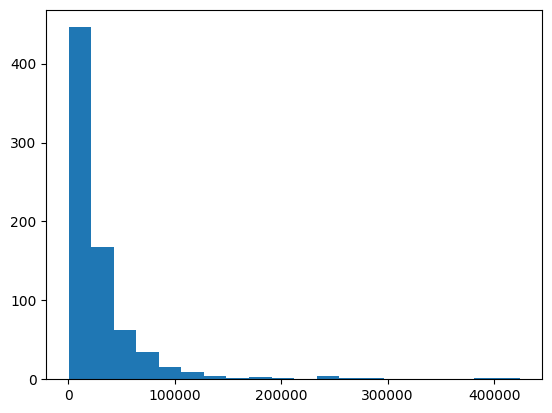

In [33]:
threads_str = []
for t in threads2show:
    posts_thread = posts_df[posts_df['thread_id'] == t]
    str_thread = f"Board: {posts_thread['board_name'].iloc[0]}\n"
    str_thread += f"Thread: {posts_thread['thread_title'].iloc[0]}\n" 
    for i, row in posts_thread.iterrows():
        str_thread += f"Post by {row['username']} "
        if row['moderator']:
            str_thread += "(moderator) "
        if row['admin']:
            str_thread += "(admin) "
        if row['staff']:
            str_thread += "(staff) "
        str_thread += f"at {row['created_at']}. "
        str_thread += f"Trust level: {row['trust_level']}.\n"
        str_thread += f"{row['content']}\n\n"

    threads_str.append(str_thread)


lengths = [len(t) for t in threads_str]
plt.hist(lengths, bins=20)

In [45]:
from datetime import date
today = date.today().strftime("%Y-%m-%d")
today

'2024-06-19'

In [48]:
# ask the chat for creating questions and answers
def answer_template():
    return f"""From the following thread from the Optimism Governance Forum, write some general questions (maximum 5, it is not a problem to do less or even none) that summarize the content. 
    
Avoid questions: 
- That make sense only in the context of the specific thread,
- That are too specific or irrelevant.
    
If there are no questions or only irrelevant ones, return blank. Give the answers to the questions as well. 

Attention:
- Some posts may be outdated or talk about specific events that took place in the past (today is: {today}). Make a disclaimer if necessary.
- High trust level users are more likely to provide relevant information (specially for answers).

<thread>
{{context}} 
</thread>

Questions and answers should be in the following format:
"question1", "answer1"
"question2", "answer2"
...
"""

prompt = ChatPromptTemplate.from_template(answer_template())

chain = prompt | llm

In [51]:
csv_location =  "first_test_dataset.csv"
out_csv_str = '"fragment", "question", "answer"'
frag = 0

with open(csv_location, 'w') as file:
    file.write(out_csv_str)

for t in threads_str:
    response = chain.invoke(
        {
            "context" : t
        }
    )
    
    response_str = "\n" + response.content
    response_str = response_str.replace("\n\n", "\n")

    # remove the \n at the end of the string if it exists
    if response_str[-1] == "\n":
        response_str = response_str[:-1]

    response_str = response_str.replace("\n", f'\n"{frag}", ')

    out_csv_str += response_str

    print(response_str)
    with open(csv_location, 'a') as file:
        file.write(response_str)
    frag += 1


"0", ""

"1", "What kind of information can be found in the 'Updates and Announcements' section?", "Information about community calls, weekly governance summaries, and periodic updates from the Foundation and other partners."
"1", "What is the purpose of the 'Accountability' category?", "To increase transparency and accountability around the usage of Governance Fund grants or other relevant topics, with all claims supported by verifiable evidence and data."
"1", "What type of discussions take place in the 'Retro Funding' category?", "Discussions relating to the allocation of Retro Funding via specific rounds, including key information about these rounds."
"1", "What is the focus of the 'Governance Design' category?", "The Collective’s metagovernance strategy, which pertains to the design of how the Collective governs the governance system."
"1", "What can be found in the 'General Discussions' category?", "General and public discussions that don’t fit into other specific categories."



KeyboardInterrupt: 

In [55]:
def clean_str(out_csv_str, documents):
    # split by \n
    lines = out_csv_str.split("\n")

    # number of " per line
    n_quotes = [line.count('"') for line in lines]

    # get indexes of lines with not 6 "
    indexes_less = [i for i, n in enumerate(n_quotes) if n < 6]
    indexes_more = [i for i, n in enumerate(n_quotes) if n > 6]
    indexes_equal = [i for i, n in enumerate(n_quotes) if n == 6]

    # get the lines with more than 6 "
    lines_with_lessthan_6_quotes = [lines[i] for i in indexes_less]
    lines_with_morethan_6_quotes = [lines[i] for i in indexes_more]
    lines_out = [lines[i] for i in indexes_equal]
    
    """lines_less_new = []
    l_old = []
    for l in lines_with_lessthan_6_quotes:
        if l_old[:4] == l[:4]:
            l = l_old + "\n " + l[6:]
        else:
            lines_less_new.append(l_old)
            None
        
        l_old = l

    lines_out.extend(lines_less_new)"""

    l_temp = []
    for l in lines_out:
        if len(l) > 0:
            # each line is in the format "fragment", "question", "answer", so we split
            parts = l.split('", "')
            parts[0] = parts[0][1:]
            parts[-1] = parts[-1][:-1]
            if len(parts) > 3:
                print(parts)
            l_temp.append(parts)
    
    # first line is the header
    lines_out = pd.DataFrame(l_temp[1:], columns=l_temp[0])
    
    # add the fragment column
    lines_out["fragment_text"] = lines_out["fragment"].apply(lambda x: documents[int(x)])

    # to new csv
    new_csv_location = "first_test_dataset_with_fragments.csv"
    lines_out.to_csv(new_csv_location, index=False)

    return lines_out


# load the file
with open(csv_location, 'r') as file:
    out_brut = clean_str(file.read(), threads_str)
out_brut

,fragment,question,answer,fragment_text
0,1,What kind of information can be found in the '...,"Information about community calls, weekly gove...",Board: Get Started 🌱\nThread: How to Navigate...
1,1,What is the purpose of the 'Accountability' ca...,To increase transparency and accountability ar...,Board: Get Started 🌱\nThread: How to Navigate...
2,1,What type of discussions take place in the 'Re...,Discussions relating to the allocation of Retr...,Board: Get Started 🌱\nThread: How to Navigate...
3,1,What is the focus of the 'Governance Design' c...,"The Collective’s metagovernance strategy, whic...",Board: Get Started 🌱\nThread: How to Navigate...
4,1,What can be found in the 'General Discussions'...,General and public discussions that don’t fit ...,Board: Get Started 🌱\nThread: How to Navigate...
...,...,...,...,...
1544,462,Why did Matters Town migrate to Optimism from ...,Matters Town migrated to Optimism to leverage ...,Board: General Discussions ✨ \nThread: Bringi...
1545,462,What unique challenges does Matters Town face ...,Matters Town faces challenges such as finding ...,Board: General Discussions ✨ \nThread: Bringi...
1546,462,How does Matters Town aim to sustain valuable ...,Matters Town uses a combination of ActivityPub...,Board: General Discussions ✨ \nThread: Bringi...
1547,462,What is the broader vision for Optimism accord...,Guo envisions Optimism evolving beyond a finan...,Board: General Discussions ✨ \nThread: Bringi...
